<img src="Images/DSD.PNG">

# Introduction

## About this Notebook

This notebook is a starting point for several types of analysis and is meant to work with relatively little presumptions about the data. That said, the notebook is built to work with tabular, structured data. In building this, I had the following process in mind:  Take data in csv form from any data source, upload into this workbook via the local csv or s3 upload widgets, perform basic EDA, then the user can add their own feature engineering and/or further analysis (clustering, anomaly detection, etc) from there.     

## Getting Started

1. Make sure you have data in csv
2. If data is located on your local machine, use section 2 to upload into notebook, CLICK RUN!?!?
3. If data is located in s3 bucket, use section 3 to upload into notebook, CLICK RUN?!?!
4. Section 5 provides an overview of the data (null counts and data types)
5. Section 6, includes dashboard like tools that allow a user to explore the data
6. If you like, add more feature engineering and rerun the notebook
7. If you like do deeper analysis on the data set.   

# Import Data From Local Here

In [18]:
from IPython.display import Javascript, display
from ipywidgets import widgets
import pandas as pd
import io

uploader = widgets.FileUpload(
    accept='.csv',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)

def on_upload(change):
    value = change['new']
    df = pd.read_csv(io.BytesIO(uploader.value[next(iter(uploader.value))]['content']))
    df.to_csv('use.csv')
            
uploader.observe(on_upload, 'value')

display(uploader)

FileUpload(value={}, accept='.csv', description='Upload')

C:\Users\duran\Anaconda3\lib\site-packages\traitlets\traitlets.py:1139: DtypeWarning: Columns (15,22) have mixed types.Specify dtype option on import or set low_memory=False.
  type='change',


In [22]:
try:
    df = pd.read_csv('use.csv')
except: 
    print('no input file found')

C:\Users\duran\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (16,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Import Data From S3 Here

In [37]:
key_uploader = widgets.FileUpload(
    description='Upload Keys',
    accept='.csv',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)

bucket = widgets.Text(
    placeholder='Bucket Name',
    description='Bucket:',
    disabled=False
)

key = widgets.Text(
    placeholder='File Name',
    description='Key:',
    disabled=False
)

input_dash = widgets.HBox([key_uploader,bucket,key])

display(input_dash)

In [38]:
import boto3
import pandas as pd

keys = pd.read_csv(io.BytesIO(key_uploader.value[next(iter(key_uploader.value))]['content']))


bucket = bucket.value
key = key.value

s3 = boto3.client("s3", 
                  region_name='us-gov-west-1', 
                  aws_access_key_id=keys['Access key ID'].iloc[0], 
                  aws_secret_access_key=keys['Secret access key'].iloc[0])

response = s3.get_object(Bucket=bucket, Key=key)

df = pd.read_csv(response['Body'])


StopIteration: 

# Run Notebook

In [23]:
def run_all(ev):
    display(Javascript('IPython.notebook.execute_cells_below()'))

csvbutton = widgets.Button(description="RUN")
csvbutton.on_click(run_all)
display(csvbutton)

<IPython.core.display.Javascript object>

Button(description='RUN', style=ButtonStyle())

# Results

## Import Packages, Define Helper Functions

In [24]:
#Import Required packages
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import ipywidgets as widgets
import missingno as msno
from IPython.display import display
import io

In [25]:
def top10(df,column,direction):
    '''This function performs an aggregation of a pandas dataframe according to unique values in a specified column and then sorts
    according to the count of records for each unique value.  In addition, the function removes missing values and
    also takes the mean of CERTVALIDTIME and CERTVALIDTIMEREMAINING for each unique value.  
    
    The function takes a data frame and a specified column as an input and returns a dataframe of aggregated values
    '''
    df_g = df
    #ignore empty or nan values
    df_g[column] = df[column].replace(np.nan, 'Missing', regex=True)
    df_g[column] = df_g[column].replace('', 'Missing', regex=True)
    #df_g = df_g[df_g[column] != 'Missing']
    
    #coerce all data into string
    df[column].astype(str)
    
    #take dir value from dropdown and assign it boolean value accordingly
    if direction == 'Ascending':
        d = True
    else:
        d = False
        
    #create new dataframe with aggregated data grouped by unique values in defined column
    df_g = df_g.groupby(column).agg({'Id': 'count'})
    df_g.columns = ['Count']
    
    df_g = df_g.sort_values(by=['Count'],ascending=d)
    
    return df_g
    
def top10Common(feature,direction,count):
    '''
    This handles events from 3 different selector widgets in the display of categorical data in the section for Displaying and
    Ploting Basic Info in the  Dataset.  Clears the current output and regenerates a new chart and table according to the newest column in the 
    dataframe selected. 
    '''
    #clear previous output
    output_feat1.clear_output()
    plot_output1.clear_output()
    
    #convert float values from widget to integers
    count = int(count)
    
    # redefine the dataframe using new column, direction values and row count according to widget inputes
    with output_feat1:
        display(top10(df,feature,direction).head(count))
    
    # redefine the plot using new column, direction values and row count according to widget inputes
    with plot_output1:
        top = top10(df,feature,direction)
        layout = go.Layout(xaxis=dict(type='category'))
        fig_2 = go.Figure(data=[go.Bar(
                    x=top.index[0:count], y=top['Count'].iloc[0:count],
                    text=top['Count'].iloc[0:count],
                    textposition='auto',
                    )],layout=layout)
        
        fig_2.update_layout(title_text='Top {} {}'.format(count,feature))

        fig_2.show()
        
def dirEventHandler(change):
    #This handles events from widgets, updates the common function with new value from dir widget, keeping old from others
    top10Common(dropdown_feature.value,change.new,slider.value)
    
def featEventHandler(change):
    #This handles events from widgets, updates the common function with new value from feat widget, keeping old from others
    top10Common(change.new,dropdown_dir.value,slider.value)
    
def countHandler(change):
    #This handles events from widgets, updates the common function with new value from slider widget, keeping old from others
    top10Common(dropdown_feature.value,dropdown_dir.value,change.new)
        
        
def EntryEventHandler(change5):
    '''
    This function handles events in the blacklist section of the notebook.   
    Clears previous dataframe and generates a new filtered according the string entered selected by the user.   
    '''
    EntryCommon(change5.new,dropdown2.value)

        
def ColumnEventHandler(change6):
    EntryCommon(entry2.value,change6.new)
        
def EntryCommon(entry,column):
    #clear previous output
    output_df2.clear_output()
    
    with output_df2:
        dfUse2 = search_df[search_df[column].str.contains(entry)]
        display(dfUse2)
    
def histcommon(feature,direction,count):
    '''
    This handles events from 3 different selector widgets in the display of numeric data (histogram) in the section for
    Displaying and Ploting Basic Info in the  Dataset.  Clears the current output and regenerates a new chart and table
    according to the newest column in the dataframe selected. 
    '''
    output_feat2.clear_output()
    plot_output2.clear_output()
    
    if direction == 'Ascending':
        d = True
    else:
        d = False
    
    with output_feat2:
        display(df.sort_values(by=[feature],ascending=d).filter([feature]).reset_index(drop=True).head(int(count)))

    with plot_output2:
        df_g = df.sort_values(by=[feature],ascending=d).filter([feature])
        fig = px.histogram(df_g[feature], x=feature,nbins=60)
        fig.show()
        
def dirEventHandler2(change2):
    #This handles events from widgets, updates the common function with new value from dir widget, keeping old from others
    histcommon(dropdown_feature2.value,change2.new,slider2.value)
    
def featEventHandler2(change2):
    #This handles events from widgets, updates the common function with new value from feat widget, keeping old from others
    histcommon(change2.new,dropdown_dir2.value,slider2.value)
    
def countHandler2(change2):
    #This handles events from widgets, updates the common function with new value from slider widget, keeping old from others
    histcommon(dropdown_feature2.value,dropdown_dir2.value,change2.new)

## Data Overview (Nulls and Data Type)

### Visualize Null Values

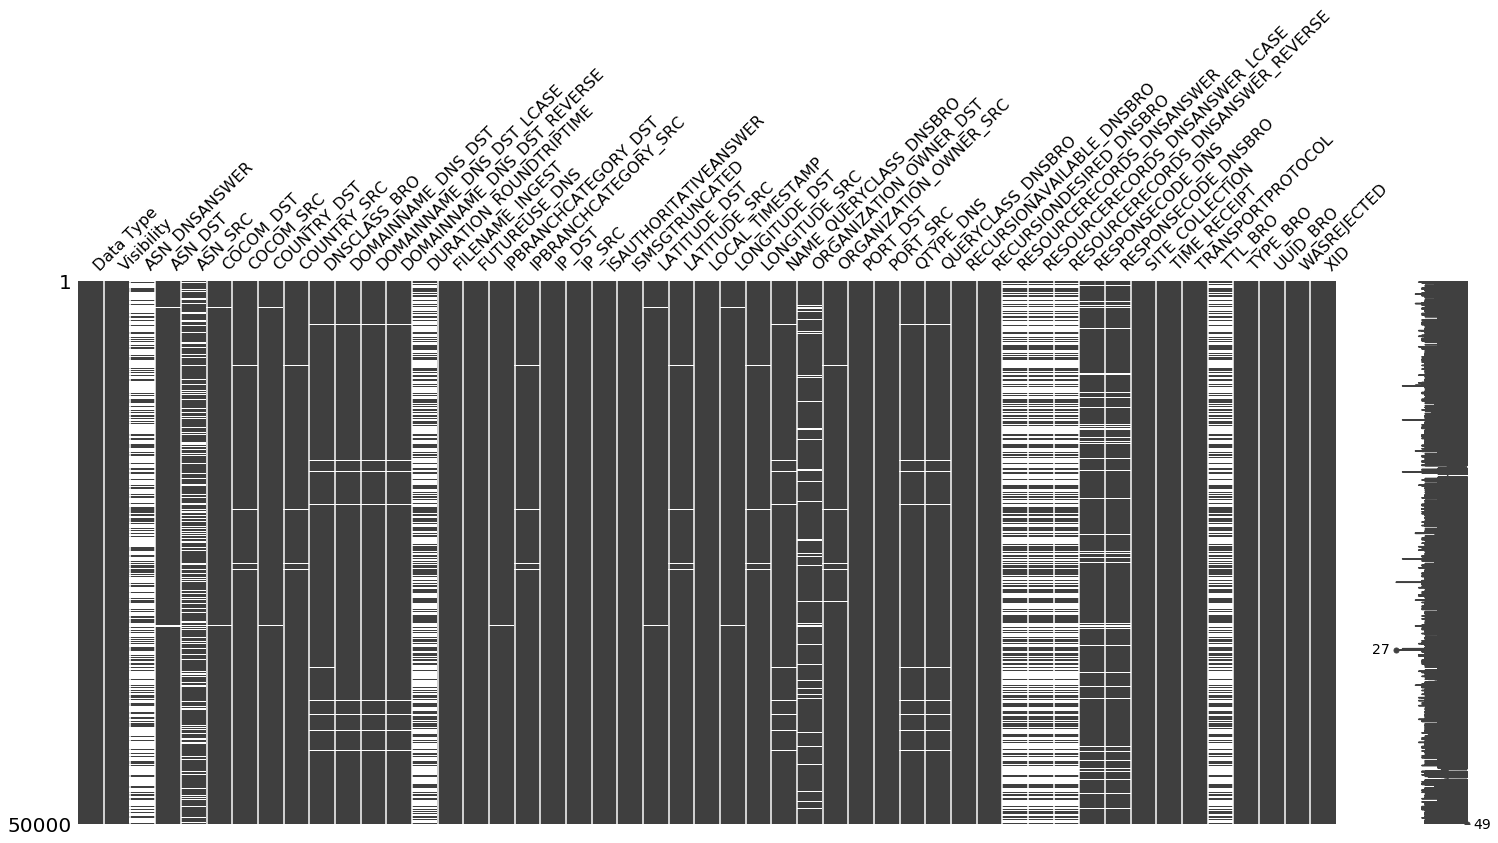

In [26]:
#msno allows for very easy visualization of null values (white spaces), excluded less interesting columns to make readible
msno.matrix(df.iloc[:,3:])

### Remove columns that are Nearly all Null

In [27]:
#define threshold for columns to remove (remove columns that are greater than thresh% null)
thresh = 0.95

#use dropna to remove values
df = df.dropna(thresh=len(df)*(1-thresh),axis=1)

#inspect remaining columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 52 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         50000 non-null  int64  
 1   Id                                 50000 non-null  object 
 2   Timestamp                          50000 non-null  float64
 3   Data Type                          50000 non-null  object 
 4   Visibility                         50000 non-null  object 
 5   ASN_DNSANSWER                      18746 non-null  object 
 6   ASN_DST                            49869 non-null  float64
 7   ASN_SRC                            37463 non-null  float64
 8   COCOM_DST                          49914 non-null  object 
 9   COCOM_SRC                          49719 non-null  object 
 10  COUNTRY_DST                        49914 non-null  object 
 11  COUNTRY_SRC                        49719 non-null  obj

## Value Count Chart and Rankings

In [28]:
#choose categorical data features to show sorted counts of
options = df.columns

dropdown_feature = widgets.Dropdown(options = options)

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

dropdown_dir = widgets.Dropdown(options = ['Descending','Ascending'])

slider = widgets.BoundedFloatText(min=1, max=1000,step=1,description='Top N:',value=10)

output_feat1 = widgets.Output()
plot_output1 = widgets.Output()

dropdown_feature.observe(featEventHandler, names='value')
dropdown_dir.observe(dirEventHandler, names='value')
slider.observe(countHandler,names='value')

tab = widgets.Tab([plot_output1,output_feat1])
tab.set_title(0, 'Plot Top/Bottom')
tab.set_title(1, 'Explore Data')

dashboard = widgets.VBox([widgets.HBox([dropdown_feature, dropdown_dir,slider]), tab])
display(dashboard)

## Histogram - Need to Manually Input Features

In [29]:
#choose numeric features to display in histogram and in explore data tab
input_list = ['SELECT FEATURE']


dropdown_feature2 = widgets.Dropdown(options = input_list)
dropdown_dir2 = widgets.Dropdown(options = ['Descending','Ascending'])
slider2 = widgets.BoundedFloatText(min=1, max=1000,step=1,description='N:',value=10)

output_feat2 = widgets.Output()
plot_output2 = widgets.Output()

dropdown_feature2.observe(featEventHandler2, names='value')
dropdown_dir2.observe(dirEventHandler2, names='value')
slider2.observe(countHandler2, names='value')

tab = widgets.Tab([plot_output2,output_feat2])
tab.set_title(0, 'Plot Histogram')
tab.set_title(1, 'Explore Data')

dashboard = widgets.VBox([widgets.HBox([dropdown_feature2, dropdown_dir2,slider2]), tab])
display(dashboard)

## Custom Filter

In [30]:
pd.set_option('display.max_columns', None)

search_df = df.fillna('NA')
search_df = search_df.replace(np.nan, 'NaN', regex=True)
search_df = search_df.applymap(str)

output_df2 = widgets.Output()

entry2 = widgets.Text(
    placeholder='Type Something',
    description='Search:',
    disabled=False
)

dropdown2 = widgets.Dropdown(description = 'In Column:',options = df.columns)

entry2.observe(EntryEventHandler,names='value')
dropdown2.observe(ColumnEventHandler,names='value')

dashboard3 = widgets.VBox([widgets.HBox([entry2, dropdown2]), output_df2])

In [31]:
display(dashboard3)